In [179]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [180]:
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Device 0: NVIDIA GeForce RTX 3070 Laptop GPU


In [181]:
DATA_PATH = Path("datasets/CMaps/")
TRAIN_FILE = DATA_PATH / "train_FD001.txt"
TEST_FILE = DATA_PATH / "test_FD001.txt"
RUL_FILE = Path(DATA_PATH / "RUL_FD001.txt")

In [182]:
def load_dataset(path):
    col_names = ["unit", "time", "os1", "os2", "os3"] + [f"s_{i}" for i in range(1, 22)]
    return pd.read_csv(path, sep=" ", header=None, names=col_names, usecols=range(26))

train_df = load_dataset(TRAIN_FILE)
test_df = load_dataset(TEST_FILE)
rul_truth = pd.read_csv(RUL_FILE, header=None)[0]


In [183]:
def add_rul(df):
    max_cycle = df.groupby("unit")["time"].max().reset_index()
    max_cycle.columns = ["unit", "max"]
    df = df.merge(max_cycle, on="unit", how="left")
    df["RUL"] = df["max"] - df["time"]
    df.drop(columns=["max"], inplace=True)
    return df

In [184]:
train_df = add_rul(train_df)
train_df.head()
drop_cols = ["unit", "time", "s_1", "s_5", "s_6", "s_10", "s_16", "s_18", "s_19"]
train_df = train_df.drop(columns=drop_cols)

# Normalize sensor data
feature_cols = [col for col in train_df.columns if col != "RUL"]
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])

# Use last cycle from test data as input
test_last = test_df.groupby("unit").last().reset_index()
test_last[feature_cols] = scaler.transform(test_last[feature_cols])
test_last["RUL"] = rul_truth


In [185]:
class EngineDataset(Dataset):
    def __init__(self, df):
        self.X = df[feature_cols].values.astype(np.float32)
        self.y = df["RUL"].values.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EngineDataset(train_df)
test_dataset = EngineDataset(test_last)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True,num_workers=15)
test_loader = DataLoader(test_dataset, batch_size=1,pin_memory=True,num_workers=15)


In [188]:
class RULANN(nn.Module):
    def __init__(self, input_dim):
        super(RULANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RULANN(input_dim=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [189]:
EPOCHS = 20
patience = 100
best_loss = float('inf')
trigger_times = 0

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    # --- Early Stopping Logic ---
    if epoch_loss < best_loss - 1e-4:  # small threshold to prevent tiny fluctuations
        best_loss = epoch_loss
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"No improvement for {trigger_times} epoch(s)")
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 1, Loss: 1321532.1641
Epoch 2, Loss: 1307563.6621
Epoch 3, Loss: 1286091.1865
Epoch 4, Loss: 1255227.3096
Epoch 5, Loss: 1216476.4717
Epoch 6, Loss: 1168046.9355
Epoch 7, Loss: 1116733.5967
Epoch 8, Loss: 1060821.5508
Epoch 9, Loss: 1000256.0771
Epoch 10, Loss: 937355.9014
Epoch 11, Loss: 866170.7998
Epoch 12, Loss: 795596.1348
Epoch 13, Loss: 726271.4097
Epoch 14, Loss: 658709.7837
Epoch 15, Loss: 595177.0249
Epoch 16, Loss: 535537.5933
Epoch 17, Loss: 479623.9468
Epoch 18, Loss: 428520.0122
Epoch 19, Loss: 382891.2769
Epoch 20, Loss: 342895.2378


In [190]:
model.eval()
preds, targets = [], []
with torch.no_grad():
    for inputs, target in test_loader:
        inputs, target = inputs.to(device), target.to(device)
        pred = model(inputs)
        preds.append(pred.item())
        targets.append(target.item())

mae = mean_absolute_error(targets, preds)
rmse = np.sqrt(mean_squared_error(targets, preds))
r2 = r2_score(targets, preds)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

MAE:  28.51
RMSE: 33.33
R²:   0.3568


already good values with no historical data and low epoch

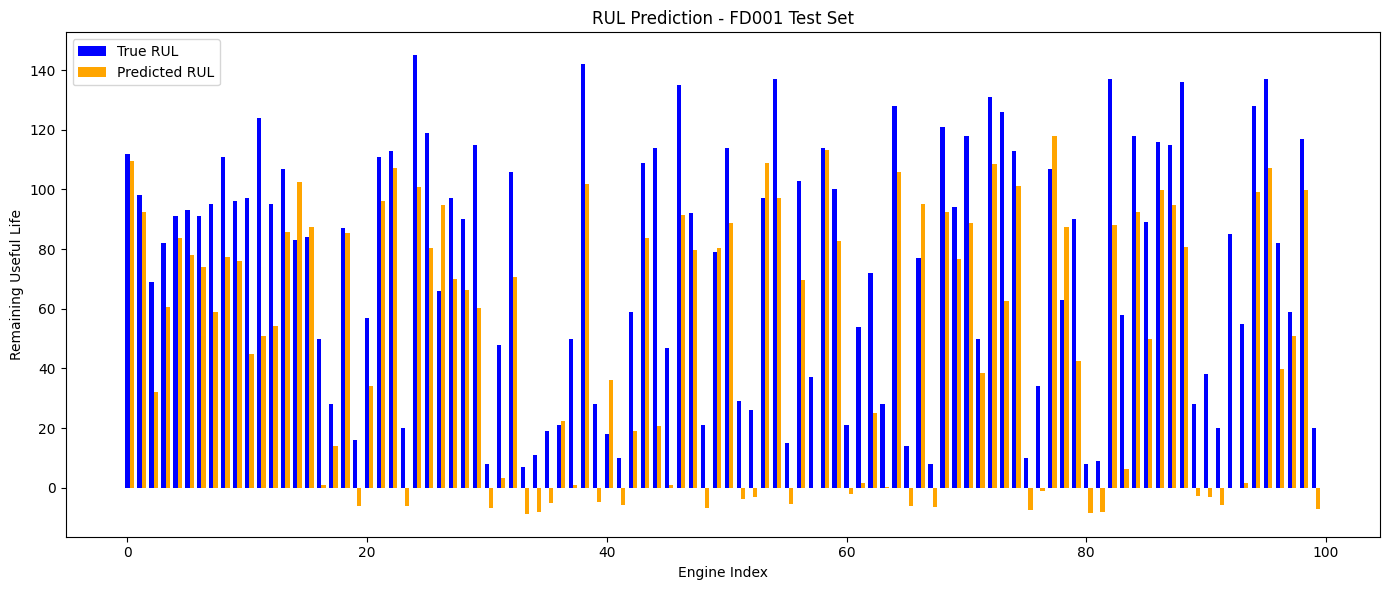

In [191]:
plt.figure(figsize=(14, 6))
indices = np.arange(len(targets))

bar_width = 0.35
plt.bar(indices, targets, bar_width, label="True RUL", color='blue')
plt.bar(indices + bar_width, preds, bar_width, label="Predicted RUL", color='orange')

plt.xlabel("Engine Index")
plt.ylabel("Remaining Useful Life")
plt.title("RUL Prediction - FD001 Test Set")
plt.legend()
plt.tight_layout()
plt.show()